# 5. The effect of individual variants

Here, we will show how to predict the effect of individual variants (which is faster than mutating all positions (ISM)). For the tutorial, we will use a list of schizophrenia related mutations (which you can find at Zenodo), but you also upload your own list of course.

You can either train the models yourself (see previous tutorials) or download the trained models from Zenodo. 

In [1]:
import os
import copy as cp
import h5py
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

### Read the list with mutations

In [2]:
mut = pd.read_csv('../../Zenodo/human/M1/scz_final_filtered.csv', sep='\t')
mut.iloc[:5]

,Variant and risk allele,Mapped gene,Location,chrom,pos,TSS,strand,coordinate
0,rs5757730-<b>G</b>,CACNA1I,22:39571425,22,39571425,39570753,+,7672
1,rs7288455-<b>A</b>,CACNA1I,22:39570542,22,39570542,39570753,+,6789
2,rs61123830-<b>A</b>,GRAMD1B,11:123522138,11,123522138,123525636,+,3502
3,rs77502336-<b>C</b>,GRAMD1B,11:123523928,11,123523928,123525636,+,5292
4,rs7927176-<b>?</b>,GRAMD1B,11:123525156,11,123525156,123525636,+,6520


Look which genes are in the list

In [3]:
mut_genes = np.unique(mut['Mapped gene'])
mut_genes

array(['CACNA1I', 'CENPM', 'CHRNA3', 'CORO7', 'CORO7-PAM16', 'CYP2D7',
       'EPO', 'GRAMD1B', 'HFE', 'HLA-B', 'HLA-DMB', 'HLA-DQA1',
       'HLA-DQB1', 'HLA-DRB5', 'KCNG2', 'KLC1', 'MROH6', 'NOTCH4',
       'SFTA2', 'ZNF318'], dtype=object)

### Load sequences and half-life times

In [4]:
fn_seq = '../../Zenodo/human/human_seq_hl.h5'
hf = h5py.File(fn_seq, 'r', libver='latest', swmr=True)
gn = np.asarray(hf['geneName']).astype('U30')
hf.close()

In [5]:
idx = np.isin(gn,mut_genes)

In [6]:
TSS = 70000
upstream = 7000
downstream = 3500

hf = h5py.File(fn_seq, 'r', libver='latest', swmr=True)
genes = np.asarray(hf['geneName']).astype('U30')[idx]
sequences = np.asarray(hf['promoter'])[idx,(TSS-upstream):(TSS+downstream),:]
hl = np.array(hf['data'])[idx]
hf.close()

### Initialize the model

In [7]:
os.chdir('../code')

from scEP_cp import CNN1D, evaluate_mut, load_checkpoint

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("[*] Selected device: ", device)

net = CNN1D(num_ct=20).to(device)
print(net)

[*] Selected device:  cuda
CNN1D(
  (conv): Sequential(
    (0): Conv1d(4, 128, kernel_size=(6,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=30, stride=30, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=1125, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.00099, inplace=False)
    (3): Linear(in_features=64, out_features=20, bias=True)
  )
)


In [9]:
os.chdir('../tutorials/')

### Load true expression values

We need this to undo the z-scoring after we made the predictions

In [10]:
y_true = pd.read_csv('../../Zenodo/human/M1/subclass/subclass.csv', index_col=0)
y_true.iloc[:5]

,Astro,Endo,L2/3 IT,L5 ET,L5 IT,L5/6 NP,L6 CT,L6 IT,L6 IT Car3,L6b,Lamp5,Micro-PVM,OPC,Oligo,Pvalb,Sncg,Sst,Sst Chodl,VLMC,Vip
WASH7P,-1.305739,-4.0,-0.915789,-0.804866,-0.886611,-0.890142,-0.931289,-0.899425,-0.812872,-0.812913,-1.041932,-4.000000,-1.140033,-1.483413,-0.938450,-1.046027,-1.220408,-0.766559,-4.0,-1.156658
LOC105379213,-4.000000,-4.0,-1.719671,-1.709472,-1.746770,-1.818924,-1.743273,-1.814571,-1.766845,-1.823213,-1.990441,-4.000000,-4.000000,-2.708975,-1.860694,-2.192155,-2.322475,-4.000000,-4.0,-2.150215
LOC729737,-4.000000,-4.0,-0.804495,-0.592176,-0.589227,-0.887951,-0.675321,-1.076636,-0.921747,-1.009648,-1.608346,-0.841344,-4.000000,-4.000000,-1.409335,-1.598436,-1.341327,-0.601251,-4.0,-1.739975
LOC100996442,-4.000000,-4.0,-1.960665,-1.708663,-1.642896,-2.124793,-1.780221,-2.514511,-1.766845,-2.298319,-2.291173,-4.000000,-4.000000,-4.000000,-1.963272,-4.000000,-1.881051,-4.000000,-4.0,-2.450456
LOC102725121,-4.000000,-4.0,-2.678668,-4.000000,-2.791185,-4.000000,-2.824471,-4.000000,-4.000000,-4.000000,-2.893829,-4.000000,-4.000000,-2.629401,-3.143388,-4.000000,-4.000000,-4.000000,-4.0,-4.000000


In [11]:
ct_mapping = y_true.columns

### Mutate the sequences

In [15]:
os.chdir('../../Zenodo/human/M1/subclass/')

numgenes = 18138
idx_all = np.arange(0,numgenes)
alphabet = 'ACTG'
ohdict = dict((i, c) for i, c in enumerate(alphabet))

# Models by positions by cell types by mutations
diff_all = np.zeros((5, len(mut), 20, 4))

for k in tqdm(range(len(mut_genes))):
    g = genes[k]
    print(g)

    kf = KFold(n_splits=20, shuffle=True, random_state=1)
    fold = 0
    fold_needed = -1
    
    # Find in which test fold this gene is
    for train_val_idx, idx_test in kf.split(idx_all):
        if np.isin(g, gn[idx_test]):
            print('We need fold: ' + str(fold))
            fold_needed = fold

            np.random.seed(fold)
            idx_rest = np.random.permutation(numgenes-len(idx_test))
            idx_val = train_val_idx[idx_rest[:1000]]
            idx_train = train_val_idx[idx_rest[1000:]]
            
            scaler = StandardScaler()
            scaler.fit(y_true.loc[gn[idx_train]])

        fold += 1
    
    mutations_g = np.where([mut['Mapped gene'] == g])[1]
    
    # Mutate sequence
    for m in range(5):

        os.chdir('logmean_multitask_' + str(fold_needed) + '/ckpt_dir' + str(m))

        load_checkpoint(net, filename='model_best.pth.tar')
        
        # Original prediction
        y_pred = evaluate_mut(device, net, 
                              np.reshape(np.transpose(sequences[k]), (1,4,10500)),
                              np.reshape(hl[k], (1,-1)))
        y_pred_inv = scaler.inverse_transform(y_pred)

        seq = np.reshape(cp.deepcopy(sequences[k]), (1,10500,4))
        
        # Iterate over the mutations related to that gene
        for index_m in mutations_g:
            
            i = mut['coordinate'][index_m]
            diff_posi = np.zeros((20,4))
            
            # Iterate over the three possible mutations
            for j in range(3):

                # Induce mutations
                idx_original = np.argmax(seq[:,i])
                idx_tochange = (idx_original+j+1) % 4
                seq_ = cp.deepcopy(seq)
                seq_[0,i,idx_original] = 0
                seq_[0,i,idx_tochange] = 1

                # Evaluate mutated sequence
                pred_ = evaluate_mut(device, net, 
                                     np.reshape(np.transpose(seq_), (1,4,10500)),
                                     np.reshape(hl[k], (1,-1)))
                pred_inv = scaler.inverse_transform(pred_)


                diff_posi[:,idx_tochange] = pred_inv - y_pred_inv

            diff_all[m, index_m] = diff_posi
            
        os.chdir('../../')

  0%|          | 0/20 [00:00<?, ?it/s]

CACNA1I
We need fold: 0

[*] Loaded checkpoint at epoch 16

[*] Loaded checkpoint at epoch 20

[*] Loaded checkpoint at epoch 26

[*] Loaded checkpoint at epoch 18

[*] Loaded checkpoint at epoch 20
CENPM
We need fold: 14

[*] Loaded checkpoint at epoch 16

[*] Loaded checkpoint at epoch 17

[*] Loaded checkpoint at epoch 18

[*] Loaded checkpoint at epoch 12

[*] Loaded checkpoint at epoch 20
CHRNA3
We need fold: 10

[*] Loaded checkpoint at epoch 17

[*] Loaded checkpoint at epoch 17

[*] Loaded checkpoint at epoch 24

[*] Loaded checkpoint at epoch 22

[*] Loaded checkpoint at epoch 26
CORO7
We need fold: 0

[*] Loaded checkpoint at epoch 16

[*] Loaded checkpoint at epoch 20

[*] Loaded checkpoint at epoch 26

[*] Loaded checkpoint at epoch 18

[*] Loaded checkpoint at epoch 20
CORO7-PAM16
We need fold: 2

[*] Loaded checkpoint at epoch 12

[*] Loaded checkpoint at epoch 20

[*] Loaded checkpoint at epoch 16

[*] Loaded checkpoint at epoch 27

[*] Loaded checkpoint at epoch 19
CYP2

In [16]:
diff_mean = np.mean(diff_all, axis=0)

### Plot the results

In [17]:
mut['variant'] = ''

for i in range(len(mut)):
    mut['variant'][i] = mut['Variant and risk allele'][i].split('-')[0]

mut['gene-var'] = mut['Mapped gene'] + '-' + mut['variant']
mut.iloc[:5]

C:\Users\LCMMIC~1\AppData\Local\Temp/ipykernel_16848/2801436316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut['variant'][i] = mut['Variant and risk allele'][i].split('-')[0]


,Variant and risk allele,Mapped gene,Location,chrom,pos,TSS,strand,coordinate,variant,gene-var
0,rs5757730-<b>G</b>,CACNA1I,22:39571425,22,39571425,39570753,+,7672,rs5757730,CACNA1I-rs5757730
1,rs7288455-<b>A</b>,CACNA1I,22:39570542,22,39570542,39570753,+,6789,rs7288455,CACNA1I-rs7288455
2,rs61123830-<b>A</b>,GRAMD1B,11:123522138,11,123522138,123525636,+,3502,rs61123830,GRAMD1B-rs61123830
3,rs77502336-<b>C</b>,GRAMD1B,11:123523928,11,123523928,123525636,+,5292,rs77502336,GRAMD1B-rs77502336
4,rs7927176-<b>?</b>,GRAMD1B,11:123525156,11,123525156,123525636,+,6520,rs7927176,GRAMD1B-rs7927176


In [18]:
effect_all = pd.DataFrame(data=np.zeros((2940, 5)), columns=['subclass', 'class', 'mutation', 'gene-variant', 'effect'])
effect_all = effect_all.astype({"subclass": str, "class": str, "mutation": str, "gene-variant": str})

count = 0

for i in range(49):
    for k in  range(4):
        
        if(np.sum(diff_mean[i], axis=0)[k]):
        
            for j in range(20):

                effect_all['gene-variant'][count] = mut['gene-var'][i]
                effect_all['mutation'][count] = ohdict[k]
                effect_all['effect'][count] = diff_mean[i,j,k]
                count += 1


C:\Users\LCMMIC~1\AppData\Local\Temp/ipykernel_16848/3985133562.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_all['gene-variant'][count] = mut['gene-var'][i]
C:\Users\LCMMIC~1\AppData\Local\Temp/ipykernel_16848/3985133562.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_all['mutation'][count] = ohdict[k]
C:\Users\LCMMIC~1\AppData\Local\Temp/ipykernel_16848/3985133562.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

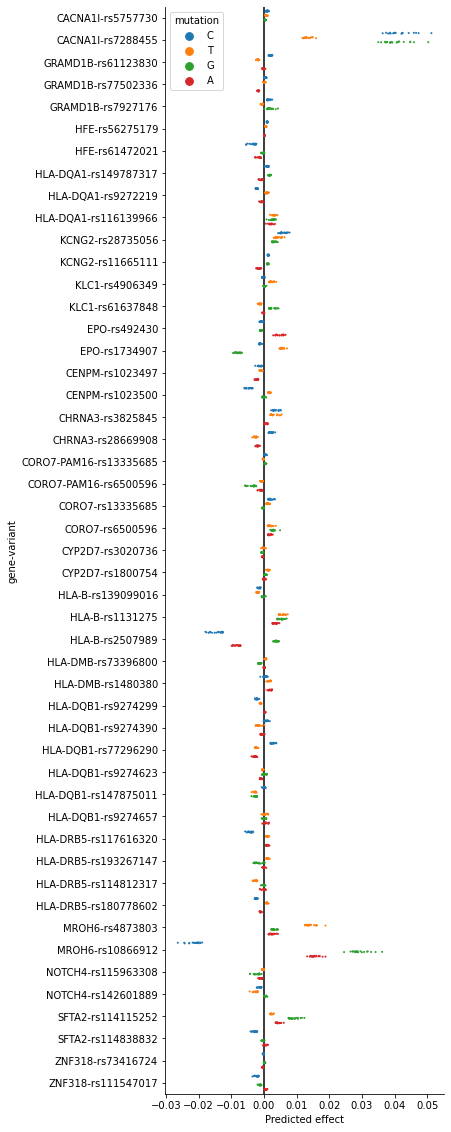

In [19]:
plt.figure(figsize=[5,20])
plt.axvline(0, color='k')
sns.stripplot(data=effect_all, y='gene-variant', x='effect', hue='mutation', dodge=True, s=2, rasterized=True)
plt.xlabel('Predicted effect')
sns.despine()
plt.show()